# Data Wrangling Pipeline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from glob import glob

## Loading tsv files

We load in all of the available data into dataframes inside of a `db` object. For example, `db['vn']` gets you the df for VN information.

In [2]:
votes = pd.read_csv("./data/vndb-votes-2024-02-03/vndb-votes-2024-02-03", delim_whitespace=True, names=['vn_id', 'user_id', 'vote', 'date'])

In [3]:
folder_path = "./data/vndb-db-2024-02-03/db"
folder = Path(folder_path)
header_files = map(Path, glob(str(folder / "*.header")))
db = {}
for header_file in header_files:
    file_name = header_file.stem
    with open(header_file, 'r') as f:
        columns = f.readline().strip().split('\t')
    csv_file = folder / file_name
    df = pd.read_csv(csv_file, delimiter='\t', names=columns, na_values=['\\N'])
    db[file_name] = df

/tmp/ipykernel_3033/4233171880.py:10: DtypeWarning: Columns (44,45,46,49,50,51,53,54,55,56,57,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, delimiter='\t', names=columns, na_values=['\\N'])


For a quick overview of the tables:

In [5]:
for db_entry, df in db.items():
    print(db_entry)
    print("---------------------------")
    print(df.info())
    print()

images
---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319094 entries, 0 to 319093
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 319094 non-null  object
 1   width              319094 non-null  int64 
 2   height             319094 non-null  int64 
 3   c_votecount        319094 non-null  int64 
 4   c_sexual_avg       319094 non-null  int64 
 5   c_sexual_stddev    319094 non-null  int64 
 6   c_violence_avg     319094 non-null  int64 
 7   c_violence_stddev  319094 non-null  int64 
 8   c_weight           319094 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 21.9+ MB
None

releases
---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112838 entries, 0 to 112837
Data columns (total 64 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                112

## Data processing

For our first iteration of the model, we primarily need data for users, vns, and their interactions. 

We already have `votes`, which is the interaction matrix. There's not much explicit data on the users, but we can dig out latent factors later on. 

The most important part is combining VN features across tables into the one `vn` dataframe. There are a few parts we'd like to incorporate:
- Available titles (for debugging)
- Length statistics
- Tag list

In [4]:
vn, vn_titles, vn_length, tags, tags_vn = db['vn'], db['vn_titles'], db['vn_length_votes'], db['tags'], db['tags_vn']

In [6]:
vn['id'] = vn['id'].apply(lambda x: int(x[1:]))
vn_titles['id'] = vn_titles['id'].apply(lambda x: int(x[1:]))
vn_length['vid'] = vn_length['vid'].apply(lambda x: int(x[1:]))
tags_vn['vid'] = tags_vn['vid'].apply(lambda x: int(x[1:]))

In [19]:
vn = vn.set_index('id')
vn_titles = vn_titles.set_index('id')

In [27]:
vn

,olang,image,l_wikidata,c_votecount,c_rating,c_average,length,devstatus,alias,l_renai,description
id,,,,,,,,,,,
1,ja,cv20339,NaN,668,578.0,578.0,3,0,NaN,NaN,A young man named Ibuki is a college student l...
2,ja,cv29271,1274585.0,1801,741.0,741.0,3,0,NaN,NaN,Kana has a terrible disease and has spent most...
3,ja,cv21565,773981.0,5050,786.0,786.0,3,0,Uta\nうた\nUta1\nThe One Being Sung\nThe One of ...,NaN,"[url=/c411]Hakuoro[/url], a man who wakes up i..."
4,ja,cv24252,110607.0,9246,867.0,867.0,5,0,クラナド,clannad,Okazaki Tomoya is a third year high school stu...
5,ja,cv42017,683502.0,7754,862.0,862.0,5,0,LB!\nリトバス！\nritobasu\n小小克星！\n校園剋星！\nLB-EX,NaN,"Riki was a child when his parents died, leavin..."
...,...,...,...,...,...,...,...,...,...,...,...
49379,ja,cv73772,NaN,0,NaN,NaN,1,0,NaN,NaN,NaN
49380,en,cv73774,NaN,0,NaN,NaN,0,1,NaN,NaN,"You play as a man who has lost everything, but..."
49381,zh-Hans,cv73775,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN


In [21]:
title_list = vn_titles['title'].groupby('id').apply(lambda x: x.tolist())

In [22]:
tag_summary = pd.merge(tags_vn, tags, left_on='tag', right_on='id')[['vid', 'id', 'name', 'description', 'cat', 'vote']]
tag_summary = tag_summary.groupby(['vid', 'id'], as_index=False).agg({'vote': 'mean', 'name': 'first'}).sort_values(by='vote', ascending=False)
tag_summary = tag_summary.groupby('vid').head(3).groupby('vid').apply(lambda x: x['name'].tolist()).rename('tags')

In [23]:
tag_summary

vid
1        [Heroine from a Different World, Catgirl Heroi...
2        [Blood-related Brother/Sister Incest, Coming-o...
3        [Pragmatic Protagonist, Fighting Protagonist, ...
4        [Unlockable Epilogue, Male Friend, Unlockable ...
5        [Friendship, High School Student Heroine, Unlo...
                               ...                        
49375         [Female Protagonist, No Sexual Content, ADV]
49376    [Battle of Wits, Protagonist with a Face, Game...
49378             [Few Choices, Musical Themes, Afterlife]
49379                [Library, Kinetic Novel, High School]
49380    [Pre-rendered 3D Graphics, Succubus Heroine, A...
Name: tags, Length: 44253, dtype: object

In [24]:
vn_length['length'] = vn_length['length'] / 60
grouped_len = vn_length.groupby(['vid', 'speed']).agg({'length': ['median', 'mean', 'std', 'count', 'skew']})
grouped_len.columns = grouped_len.columns.droplevel()

In [25]:
simple_len = grouped_len['median'].reset_index(level='speed').pivot_table(index='vid', columns='speed', values='median')
simple_len.columns = ['median_0', 'median_1', 'median_2']

In [26]:
simple_len

,median_0,median_1,median_2
vid,,,
1,NaN,15.000000,NaN
2,21.158333,15.000000,6.500000
3,50.500000,35.000000,27.300000
4,116.500000,85.000000,55.666667
5,128.000000,86.525000,59.500000
...,...,...,...
49324,NaN,NaN,1.816667
49344,NaN,0.283333,NaN
49370,NaN,NaN,0.216667


In [42]:
# Combine collected information 
vn = pd.merge(vn, title_list, left_index=True, right_index=True, how='left')
vn = pd.merge(vn, simple_len, left_index=True, right_index=True, how='left')
vn['tags'] = tag_summary

In [52]:
vn_features = vn.copy()

In [53]:
vn_features = vn_features.drop(columns=['alias', 'devstatus', 'l_wikidata', 'image', 'c_average', 'l_renai'])

# Analysis


In [80]:
votes['user_id'].unique().shape

(68851,)

In [81]:

votes['vn_id'].unique().shape

(28337,)

<Axes: xlabel='vote', ylabel='Count'>

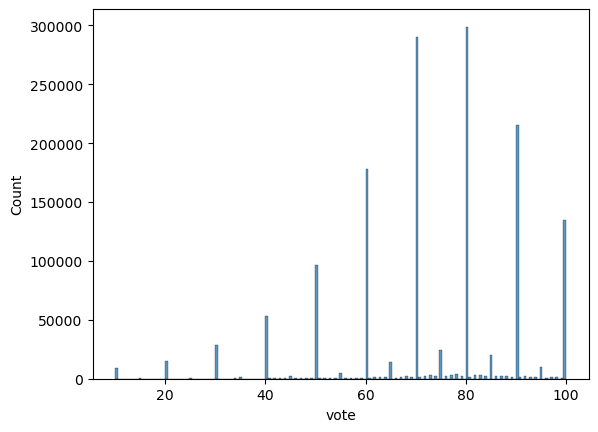

In [82]:
sns.histplot(votes['vote'])

### Visualize a user profile

In [ ]:
TEST_USER = 43708

In [ ]:
ratings = votes.merge(vn[['title', 'tags', 'c_rating', 'c_votecount']], right_index=True, left_on='vn_id').set_index("user_id")
ratings.loc[243318].sort_values(by='vote', ascending=False)

## Prepare for NCF input

Our first goal is to create a baseline NCF model with minimal features and pre-processing. This just gives us something to improve upon.

Now we need to transform our newly aggregated pieces of data into a suitable format for our neural network. 

- For now, let's ignore most of the non-numerical features to keep things simple.
- Further, we'll also get rid of unrated VNs for now. This might be preferable later on too if users don't like to be recommended super new ones. 

Now, it's time to normalize our data. 

In [54]:
from sklearn.preprocessing import MinMaxScaler

votes_without_date = votes.drop(columns=['date'])

scaler = MinMaxScaler()
votes_without_date['vote'] = scaler.fit_transform(votes_without_date['vote'].to_numpy().reshape(-1, 1))

In [57]:
store = pd.HDFStore('store.h5')

In [58]:
store['votes'] = votes_without_date
store['vn'] = vn

/tmp/ipykernel_3033/391615871.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['olang', 'image', 'alias', 'l_renai', 'description', 'title', 'tags'], dtype='object')]

  store['vn'] = vn


In [59]:
store.close()